# Ensemble of popular crop simulation models for wheat modelling
----------

Models

WOFOST, DSSAT, MONICA


Dataset

Wheat Crop Yield in Russia in different regions

In [2]:
import os, sys
import json
import pandas as pd
import datetime as dt
import subprocess
import csv
import math
import shutil



import sys
sys.path.append("../pyCropModels/")
import gc

import subprocess
from itertools import chain, product
import time

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import phenolopy

import seaborn as sns
import tqdm
# import xarray as xr


from scipy import signal
from scipy.signal import savgol_filter, wiener
from scipy.stats import zscore


import datetime as dt
import numpy as np 
import os
import requests

from math import log10, cos, sin, asin, sqrt, exp, pi, radians


import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'



## Monica settings

In [3]:
# os.environ['MONICA_PARAMETERS'] = "/home/mgasanov/agro/zalf-rpm/monica-parameters"
os.environ['MONICA_PARAMETERS'] = "/run/monica/monica-parameters/"

## Prepare weather

In [4]:
from weather_utils import NASA_MONICA

In [5]:
nasa_weather = NASA_MONICA(latitude = 51.5, longitude = 37.1)

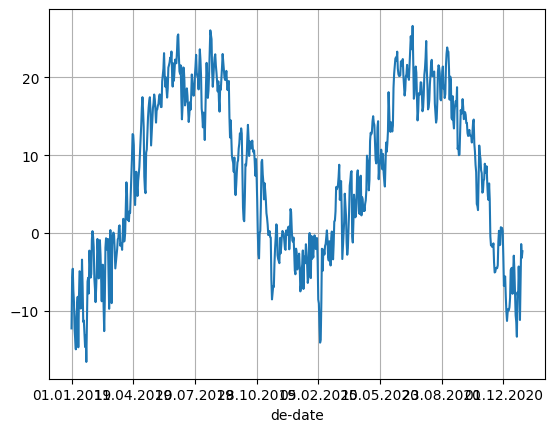

In [6]:
nasa_weather.df_monica.set_index('de-date')['tavg'].plot()
plt.grid()

## Phenology detector

* Пока не используем, для второго датасета 

In [7]:


def get_interpolated_dataset( df: pd.DataFrame, dates_season: list
) -> pd.DataFrame:
    x = df.values
    x[x < 0] = 0
    df.iloc[:, :] = x
    x = df.values
    x[x > 1] = 1
    df.iloc[:, :] = x
    df["date"] = dates_season
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")
    min_date = df.index.min()
    max_date = df.index.max()
    r = pd.date_range(start=min_date, end=max_date)
    full_df = df.copy()
    full_df = full_df.reindex(r).rename_axis("date").reset_index()
    full_df = full_df.interpolate(method="linear")
    full_df = full_df.set_index("date")
    full_df.iloc[:, :] = signal.savgol_filter(
        full_df.values, window_length=13, polyorder=1, axis=0
    )
    return full_df

def get_features( df: pd.DataFrame):
    df.index = df.index.rename("time")
    da = xr.DataArray(data=df)
    ds_phenos = phenolopy.calc_phenometrics(
        da=da,
        peak_metric="pos",
        base_metric="vos",
        factor=0.2,
        thresh_sides="two_sided",
        abs_value=0.1,
    )
    return ds_phenos.to_pandas()



## Crop dataset

In [10]:
# df_1 = pd.read_excel('../examples/dataset_1.xlsx', index_col=0)
# # df_2 = pd.read_excel('../examples/dataset_2.xlsx', skiprows=2)
# # df_2 = df_2.loc[~df_2['Год'].isna()]
# # df_2 = df_2.loc[df_2['Культура']=='Пшеница озимая']

In [11]:
df_observed_yield = pd.read_excel('../examples/dataset_1.xlsx', index_col=0)


df_observed_yield = df_observed_yield.loc[df_observed_yield['Культура 2020']=='Озимая пшеница'].reset_index()
df_observed_yield = df_observed_yield.drop(columns=['index'])
df_observed_yield = df_observed_yield.rename(columns={'Широта центра поля':'lat', 
                                  'Долгота центра поля':'lon',
                                 'Культура 2020': 'crop',
                                 'Урожайность_факт_кг':'yield'})


In [ ]:
df_observed_yield['']

In [14]:
df_observed_yield['yield'].describe()

count      67.000000
mean     5893.089552
std      1285.498403
min      1480.000000
25%      5549.000000
50%      6140.000000
75%      6785.000000
max      8959.000000
Name: yield, dtype: float64

In [13]:
df_observed_yield['Регион'].unique()

array(['Курская область', 'Воронежская область', 'Орловская область'],
      dtype=object)

## MONICA model

In [15]:
from weather_utils import get_real_soil

In [17]:
cropsDict = {'barley':{'species':'crops/barley.json', 
                       'cultivar':'crops/barley/spring-barley.json',
                       'crop-residues':'crop-residues/barley.json'},
            'soybean':{'species':'crops/soybean.json', 
                       'cultivar':'crops/soybean/000.json',
                       'crop-residues':'crop-residues/soybean.json'},
            'maize':{'species':'crops/maize.json', 
                     'cultivar':'crops/maize/grain-maize-Pioneer-30K75.json',
                     'crop-residues':'crop-residues/maize.json'},
            'wheat':{'species':'crops/wheat.json',
                     'cultivar':'crops/wheat/spring-wheat.json',
                     'crop-residues':'crop-residues/wheat.json'}}

In [24]:


def prepareCrop(path:str, 
                crop_name:str,
                planting:str,
                harvest:str)-> dict:
    
    """
    Prepare crop dict for MONICA JSON file 
    
    """
    
    
    crop_file = os.path.join(path, 'crop.json')

    with open(crop_file, 'r') as j:
         cropJson = json.loads(j.read())

    #planting date
    cropJson['cropRotation'][0]['worksteps'][0]['date'] = planting
    # harvest date
    cropJson['cropRotation'][0]['worksteps'][1]['date'] = harvest
    for target in ['species', 'cultivar']:
        cropJson['cropRotation'][0]['worksteps'][0]['crop']\
                        ['cropParams'][target][1] = cropsDict[crop_name][target]
    cropJson['cropRotation'][0]['worksteps'][0]['crop']['residueParams'][1] = cropsDict[crop_name]['crop-residues']
    
    cropfName = os.path.join(path, 'crop-monica.json')
    with open(cropfName, 'w') as file: 
        json.dump(cropJson, file, ensure_ascii=False, indent=4)

    
    return cropJson

def prepareSite(path:str,
                latitude: float, soil:list = None)-> dict:
    """
    Prepare site dict for MONICA JSON file
    
    TO-DO: add soil data from soilgrids
    
    """

    site_file = os.path.join(path, 'site.json')

    with open(site_file, 'r') as j:
         siteJson = json.loads(j.read())
    siteJson['SiteParameters']['Latitude'] = latitude

    if soil is not None:
        siteJson['SiteParameters']['SoilProfileParameters'] = soil 
    sitefName = os.path.join(path, 'site-monica.json')
    with open(sitefName, 'w') as file: 
        json.dump(siteJson, file, ensure_ascii=False, indent=4)

    return siteJson

def get_yield_value_from_csv(csv_output: str):
    with open(csv_output, 'r') as f:
        reader = csv.reader(f)
        target_line_index = None
        for i, line in enumerate(reader):
            if 'Yield' in line and 'CM-count' in line:
                target_line_index = i + 2
            elif target_line_index is not None and i == target_line_index:
                return float(line[2])

cropsDict = {'barley':{'species':'crops/barley.json', 
                       'cultivar':'crops/barley/spring-barley.json',
                       'crop-residues':'crop-residues/barley.json'},
            'soybean':{'species':'crops/soybean.json', 
                       'cultivar':'crops/soybean/000.json',
                       'crop-residues':'crop-residues/soybean.json'},
            'maize':{'species':'crops/maize.json', 
                     'cultivar':'crops/maize/grain-maize-Pioneer-30K75.json',
                     'crop-residues':'crop-residues/maize.json'},
            'wheat':{'species':'crops/wheat.json',
                     'cultivar':'crops/wheat/winter-wheat.json',
                     'crop-residues':'crop-residues/wheat.json'}}


pathMONICA = '../src/monica/monica_input/'
def run_monica(weather_fname: str, lat: float, sowing_date: str, harvest_day: str,  crop: str = 'barley'):
    model_type = 'MONICA' 
    shutil.copy2(weather_fname,os.path.join(pathMONICA, "climate-monica.csv"))

    crop_res = prepareCrop(path = pathMONICA, 
                           crop_name = crop,
                           planting = sowing_date,
                           harvest = harvest_day)
    soil = get_real_soil()
    site_res = prepareSite(path = pathMONICA, 
                           latitude=lat,
                           soil=soil)

    path_sim_file = "/notebooks/src/monica/monica_input/sim-monica.json"
    cmd = 'monica-run'    
    res_monica_run = subprocess.run([cmd, path_sim_file], universal_newlines=True)
    out_monica = pd.read_csv('./out.csv', skiprows=1, nrows=2)
    monica_yield = get_yield_value_from_csv('./out.csv')
    df = pd.read_csv('./out.csv', skiprows=[0,2], skipfooter=30, engine='python')
    return monica_yield, df
    
def download_weather(lon: float, lat:float, fname: str):
    nasa_weather = NASA_MONICA(latitude = lat, longitude = lon)
    df_weather = nasa_weather.df_pcse
    df_weather.loc[:,'de-date'] = pd.to_datetime(df_weather.loc[:,'de-date'], format='%d.%m.%Y')
    r = pd.date_range(start=df_weather.loc[:,'de-date'].min(), end=df_weather.loc[:,'de-date'].max())
    full_range_weather = df_weather.set_index('de-date').reindex(r).rename_axis('de-date').reset_index()
    filled_weather = full_range_weather.fillna(method='ffill', axis=0)      
    filled_weather.loc[:, 'de-date'] = filled_weather.loc[:, 'de-date'].dt.strftime('%d.%m.%Y')
    filled_weather.to_csv(fname, sep=';',index=False)
    return filled_weather

### Run simulations

In [28]:
monica_collector=[]
for i, row in df_observed_yield.iterrows():
    print(i,end=' ')
    data = row.to_dict()
    fname = os.path.join(pathMONICA,'NASA_MONICA.csv')
    weather = download_weather(lon=round(data['lon'],1), lat=round(data['lat'],1), fname=fname)
    monica_yield, df = run_monica(weather_fname=fname, 
                                  lat=data['lat'],
                                  sowing_date=data['Дата сева'],
                                 harvest_day=data['Дата уборки'],
                                 crop='wheat')
    monica_collector.append(monica_yield)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 

In [29]:
df_observed_yield['MONICA'] = monica_collector

In [31]:
df_observed_yield

,Площадь поля,lat,lon,Регион,crop,Культура 2019,Дата сева,Дата уборки,"Урожайность Потенциальная, кг/га","Урожайность Достижимая, кг/га",Ks (cm/h),Field Capacity,Площадь_поля,Урожайность_факт_ц,yield,MONICA
0,56.66,51.015203,35.603317,Курская область,Озимая пшеница,Соя,2019-09-09,2020-07-11,6002.002814,4268.464372,40.910660,0.375849,56.66,55.70,5570.0,5377.5
1,68.24,51.002707,35.626024,Курская область,Озимая пшеница,Соя,2019-09-09,2020-07-19,6002.002814,3553.399736,24.875625,0.363465,68.24,53.80,5380.0,6683.8
2,23.15,50.988944,35.619612,Курская область,Озимая пшеница,Кукуруза на силос,2019-09-09,2020-07-12,6002.002814,2794.504624,15.576068,0.346464,23.15,51.30,5130.0,5606.2
3,273.01,50.960686,35.665459,Курская область,Озимая пшеница,Люпин,2019-09-08,2020-07-19,6002.002814,4388.273183,36.804526,0.376198,273.01,75.90,7590.0,6676.1
4,125.42,50.978276,35.747605,Курская область,Озимая пшеница,Соя,2019-09-07,2020-07-20,6002.002814,3725.708362,23.818116,0.361591,125.42,70.70,7070.0,6869.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,370.80,53.033132,36.857263,Орловская область,Озимая пшеница,Пар,2019-08-25,2020-08-07,4343.215658,4343.215658,13.413083,0.332255,370.80,56.50,5650.0,8856.7
63,40.70,53.031030,36.827177,Орловская область,Озимая пшеница,Пар,2019-08-26,2020-08-08,4343.215658,4343.215658,10.509224,0.322851,40.70,56.10,5610.0,8884.0
64,59.89,53.042214,36.985485,Орловская область,Озимая пшеница,Пар,2019-08-26,2020-08-09,4343.215658,4343.215658,7.891736,0.313307,59.89,61.48,6148.0,8885.5
65,58.26,53.147262,36.992440,Орловская область,Озимая пшеница,Пар,2019-08-24,2020-08-04,4343.215658,4343.215658,62.338327,0.347233,58.26,58.14,5814.0,8598.5


## DSSAT model


In [32]:
from DSSATTools import Crop, SoilProfile, Weather, Management, DSSAT, available_cultivars
import DSSATTools

from weather_utils import NASA_DSSAT

In [33]:
def prepare_dssat_wth(lon: float, lat: float):
    df_weather = nasa_dssat.get_dssat_weather(latitude=lat, longitude=lon)
    df_weather['DATE'] = pd.to_datetime(df_weather['DATE'])
    weather_cols = [ 'DATE', 'TMIN', 'TMAX', 'RAD', 'RAIN', 'RHUM']
    wth = Weather(
        df_weather[weather_cols].copy(),
        pars={"DATE":'DATE',
            'TMIN': 'TMIN', 'TMAX': 'TMAX',
            'RAIN': 'RAIN', 'RAD': 'SRAD',
            'RHUM': 'RHUM'
        },
        lat=lat,
        lon= lon, 
        elev = nasa_dssat.elevation
    )
    return wth



In [34]:
nasa_dssat = NASA_DSSAT(longitude=round(data['lon'],1), latitude=round(data['lat'],1))
soil = SoilProfile(default_class='SCL')


In [41]:
# Тут можно посмотреть список культур
available_cultivars('wheat')

['999991',
 '999992',
 'DFAULT',
 'IB1500',
 'IB0488',
 'IB1015',
 'AW0071',
 'CI0001',
 'KZ0001',
 'TX0001',
 '990015']

In [65]:
dssat_container=[]
for i, row in df_observed_yield.iterrows():
    print(i,end=' ')
    data = row.to_dict()
    
    sowing_date = dt.datetime.strptime(data['Дата сева'], '%Y-%m-%d')
    harvest_date = dt.datetime.strptime(data['Дата уборки'], '%Y-%m-%d')
    
    lon=round(data['lon'],1)
    lat=round(data['lat'],1)

    wth = prepare_dssat_wth(lon=lon, lat=lat)

    crop = Crop('wheat', '999991')
    man = Management(
        planting_date=sowing_date,
#         irrigation='A'
    )
    # Modify harvest to Automatic
    man.harvest_details['HDATE'] = harvest_date.strftime('%y%j')
    man.harvest_details['HPC']=100

    try:
        dssat = DSSAT()
        dssat.setup()

        dssat.run(
            soil=soil, weather=wth, crop=crop, management=man,
        )

        output_1 = dssat.output['PlantGro']
        dssat_result = float(output_1['CWAD'].max())
        dssat_result = float(dssat.output['PlantGro']['HWAD'].max())
#         dssat.close()
    except Exception as e:
        dssat_result = -999
        print('Problmes')
        print(e)

    dssat_container.append(dssat_result)
#     break 
# 

0 /tmp/dssatjchfghvf created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  24  35 20897    21    91     0    71   192     0   -99      0  158
1 /tmp/dssatrgoyxyic created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  24  35 20897    21    91     0    71   192     0   -99      0  158
2 /tmp/dssatidjkujje created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  24  35 20897    21    91     0    71   192     0   -99      0  158
3 /tmp/dssatcsgmklay created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH 


RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  17  23   188T    0T    9     0    36   169     0   -99      0  158
32 /tmp/dssatodvjfvys created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  16 -99 20831    19     2     0    38   161     0   -99      0  158
33 /tmp/dssatthekelsl created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  16 -99 20831    19     2     0    38   161     0   -99      0  158
34 /tmp/dssatsxstcchu created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  16 -99 20831    19    


RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  17  24   128T    0T   14     0    36   174     0   -99      0  158
63 /tmp/dssatacgjbsga created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  17  25   164T    0T   19     0    39   176     0   -99      0  158
64 /tmp/dssatilgszpdt created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  17  25   164T    0T   19     0    39   176     0   -99      0  158
65 /tmp/dssatymogpeew created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  17  24   113T    0T   

In [67]:
df_observed_yield['DSSAT'] = dssat_container

## Plots

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
df_observed_yield = df_observed_yield.rename(columns={'Урожайность Потенциальная, кг/га':'WOFOST_PP',
                                 'Урожайность Достижимая, кг/га':'WOFOST_FLD'})

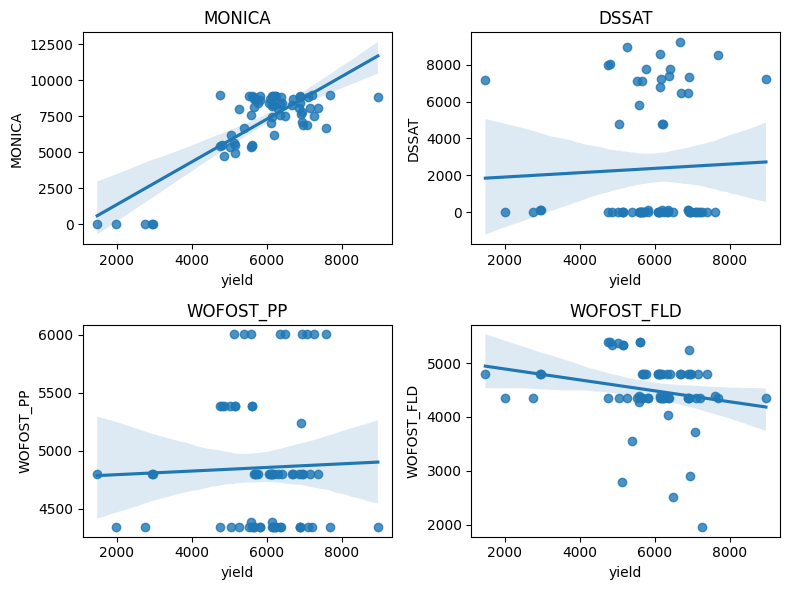

In [78]:
target = 'MONICA'
fig, axes = plt.subplots(2,2, figsize=(8,6))
axes=axes.flatten()
for i, model_type in enumerate(['MONICA', 'DSSAT', 'WOFOST_PP', 'WOFOST_FLD']):
    sns.regplot(x='yield', y=model_type, data=df_observed_yield, ax=axes[i])
    axes[i].set_title(model_type)
    
fig.tight_layout()

In [79]:
df_observed_yield.to_csv('EnsembleCropModes.csv')

## Ensemble

In [80]:
df = df_observed_yield.copy()

In [82]:
!pip3 -q install scikit-learn

In [86]:
# Простое усреднение
df['Ensemble_mean'] = df[['MONICA', 'DSSAT', 'WOFOST_PP', 'WOFOST_FLD']].mean(axis=1)


In [87]:
# Веса для каждой модели (например, можно их подбирать по метрикам качества)
weights = [0.4, 0.2, 0.2, 0.2]

# Взвешенное усреднение
df['Ensemble_weighted'] = (df['MONICA'] * weights[0] +
                           df['DSSAT'] * weights[1] +
                           df['WOFOST_PP'] * weights[2] +
                           df['WOFOST_FLD'] * weights[3])


In [83]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Выделим признаки и целевой вектор
X = df[['MONICA', 'DSSAT', 'WOFOST_PP', 'WOFOST_FLD']]
y = df['yield']

# Определяем модели и мета-модель
base_models = [
    ('MONICA', LinearRegression()),
    ('DSSAT', LinearRegression()),
    ('WOFOST_PP', LinearRegression()),
    ('WOFOST_FLD', LinearRegression())
]
meta_model = LinearRegression()

# Создаем ансамбль на основе stacking
stacking = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking.fit(X, y)

# Предсказания на основе мета-модели
df['Ensemble_stacking'] = stacking.predict(X)


In [85]:
from sklearn.linear_model import LinearRegression

# Создаем линейную регрессию и подбираем веса
lr = LinearRegression()
lr.fit(X, y)

# Оптимальные веса
optimal_weights = lr.coef_

# Ансамбль на основе оптимальных весов
df['Ensemble_ols'] = lr.predict(X)


In [93]:
df.columns

Index(['Площадь поля', 'lat', 'lon', 'Регион', 'crop', 'Культура 2019',
       'Дата сева', 'Дата уборки', 'WOFOST_PP', 'WOFOST_FLD', 'Ks (cm/h)',
       'Field Capacity', 'Площадь_поля', 'Урожайность_факт_ц', 'yield',
       'MONICA', 'DSSAT', 'Ensemble_stacking', 'Ensemble_ols', 'Ensemble_mean',
       'Ensemble_weighted'],
      dtype='object')

In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

models = ['WOFOST_PP', 'WOFOST_FLD', 'MONICA', 'DSSAT',
          'Ensemble_stacking', 'Ensemble_ols', 'Ensemble_mean','Ensemble_weighted']
print('MODEL - MAPE, %')
for model_type in models:
    mape = mean_absolute_percentage_error(df['yield'], df[model_type])
    print(model_type, round(mape*100,2))

# # MSE для усреднения
# mse_mean = mean_absolute_percentage_error(df['yield'], df['Ensemble_mean'])
# # MSE для взвешенного усреднения
# mse_weighted = mean_absolute_percentage_error(df['yield'], df['Ensemble_weighted'])
# # MSE для stacking
# mse_stacking = mean_absolute_percentage_error(df['yield'], df['Ensemble_stacking'])
# # MSE для OLS
# mse_ols = mean_absolute_percentage_error(df['yield'], df['Ensemble_ols'])

# print(f"MSE for Mean Ensemble: {mse_mean}")
# print(f"MSE for Weighted Ensemble: {mse_weighted}")
# print(f"MSE for Stacking Ensemble: {mse_stacking}")
# print(f"MSE for OLS Ensemble: {mse_ols}")


MODEL - MAPE, %
WOFOST_PP 28.56
WOFOST_FLD 33.08
MONICA 32.22
DSSAT 80.65
Ensemble_stacking 21.94
Ensemble_ols 10.28
Ensemble_mean 25.5
Ensemble_weighted 19.34


In [111]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [121]:
!apt install msttcorefonts -qq

E: Unable to locate package msttcorefonts


In [122]:
!rm ~/.cache/matplotlib -rf           # remove cache

In [127]:
plt.rcParams["font.family"] = "Times"

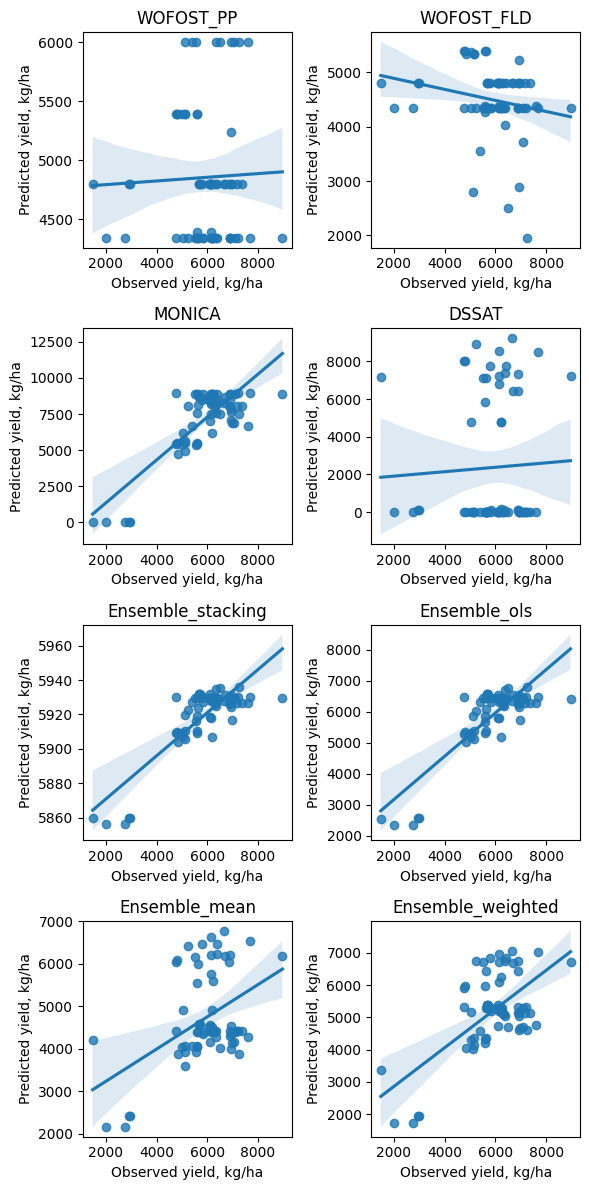

In [136]:
target = 'MONICA'
fig, axes = plt.subplots(4,2, figsize=(6,12))
axes=axes.flatten()

models = ['WOFOST_PP', 'WOFOST_FLD', 'MONICA', 'DSSAT',
          'Ensemble_stacking', 'Ensemble_ols', 'Ensemble_mean','Ensemble_weighted']
for i, model_type in enumerate(models):
    sns.regplot(x='yield', y=model_type, data=df, ax=axes[i])
    axes[i].set_title(model_type)
    axes[i].set_xlabel('Observed yield, kg/ha')
    axes[i].set_ylabel('Predicted yield, kg/ha')
    
fig.tight_layout()
plt.show()

In [92]:
df.to_csv('./EnsembleCropModes_v1.csv')

## End